# Analysis of Sphere packing efficeincy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # For calculating QPSK decoding
import dill
from itertools import product, cycle

import tensorflow.keras.backend as K

System Configuration

In [3]:
blkSize     = 8
chDim       = 4

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 11.0, 1.0 )

one_hot_code = np.eye(inVecDim)

## Traditional Systems

### QAM

In [4]:
qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

QAM Avg. Tx Power: 8.0


### Agrell Map

In [5]:
agrell_map = []
if blkSize==2 and chDim==1:
    agrell_map = np.array([
        [ -1.0, -1.0 ],
        [ -1.0, 1.0 ],
        [ 1.0, -1.0 ],
        [ 1.0, 1.0 ]
    ])
elif blkSize==4 and chDim==2:
    agrell_map = np.array([
        [2.148934030042627, 0.0, 0.0, 0.0],
        [0.7347204676695321, 1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, -1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, 0.0, 1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, -1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, 0.0, 1.4142135623730951],
        [0.7347204676695321, 0.0, 0.0, -1.4142135623730951],
        [-0.6174729817844246, 1.0, 1.0, 1.0],
        [-0.6174729817844246, 1.0, 1.0, -1.0],
        [-0.6174729817844246, 1.0, -1.0, 1.0],
        [-0.6174729817844246, 1.0, -1.0, -1.0],
        [-0.6174729817844246, -1.0, 1.0, 1.0],
        [-0.6174729817844246, -1.0, 1.0, -1.0],
        [-0.6174729817844246, -1.0, -1.0, 1.0],
        [-0.6174729817844246, -1.0, -1.0, -1.0],
        [-1.6174729817844242, 0.0, 0.0, 0.0]
    ])
elif blkSize==8 and chDim==4:
    agrell_map = np.array([
        [ -256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 0.0, -256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ] ])
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

Agrell Avg. Tx Power: 137610.0


### Compute Metrics

QAM

In [6]:
qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))

qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

qam_en = qam_sym_pow / (qam_d_min**2)
print("En:", qam_en)

QAM Avg. Tx Power: 8.0
d_min: 2.0
En: 2.0


Agrell

In [7]:
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

agrell_dmin = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_dmin )

agrell_en = agrell_sym_pow / (agrell_dmin**2)
print("En:", agrell_en)

Agrell Avg. Tx Power: 137610.0
d_min: 362.03867196751236
En: 1.0498809814453123


## Deep Learning Model

In [8]:
import sys
sys.path.insert(0, '..')
from CommVAE import CommVAE1hot
from AEOshea import AEOshea1hot
from aoudia.CommVAE_Aoudia import CommVAE1hot_Aoudia

Specify models to analyze

In [9]:
model_summary = {}
results = {}

# if blkSize==8 and chDim==4:
#     model_summary = { 
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN ($\sigma_n^2=0.8$)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF ($\sigma_n^2=0.8$)": "./models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
#         "Oshea ($10dB$)": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil"
#     }
# elif blkSize==4 and chDim==2:
#     model_summary = {
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
#         "AWGN($\sigma_n^2=0.4$)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
#         "RBF($\sigma_n^2=0.4$)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
#         "Oshea ($10dB$)": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil"
#     }
# elif blkSize==2 and chDim==1:
#     model_summary = {
        
#     }
# else:
#     raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

if blkSize==8 and chDim==4:
    model_summary = { 
#         "[1]": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
#         "Proposed: Trained with (19)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
        "Trained using Adam": "./../models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
        "Trained using [13] ($\\sigma = 0.10$)": "./models_08x04/rbf_rbf_64_32_16_n080_s010_summary.dil",
        "Trained using [13] ($\\sigma = 0.15$)": "./models_08x04/rbf_rbf_64_32_16_n080_s015_summary.dil"
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "[1]": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (19)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models_02x01/rbf_oshea_64_32_16_10dB_summary.dil",
        "Proposed: Trained with (19)": "./models_02x01/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_02x01/rbf_rbf_64_32_16_n020_summary.dil",
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [10]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

Trained using Adam                          ./../models_08x04/rbf_rbf_64_32_16_n080_summary.dil                   EXISTS
Trained using [13] ($\sigma = 0.10$)        ./models_08x04/rbf_rbf_64_32_16_n080_s010_summary.dil                 EXISTS
Trained using [13] ($\sigma = 0.15$)        ./models_08x04/rbf_rbf_64_32_16_n080_s015_summary.dil                 EXISTS


For each of the model, compute $E_n$

In [12]:
for (model_exp,summary_file) in model_summary.items():
    summary_data = {}
    file_prefix = None
    # Load file
    results[model_exp] = {}
    with open(summary_file, "rb") as file:
        file_prefix = summary_file.split("_summary.dil")[0]
        summary_data = dill.load(file)
    for (modelid,(sym_pow,bler)) in summary_data.items():
        config_file = file_prefix + "_" + modelid + ".dil"
        config = {}
        model = None
        with open(config_file, "rb") as cfg_file:
            config = dill.load(cfg_file)
        if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
            print(config_file, "    CommVAE")
            model = CommVAE1hot()
        else:
            print(config_file, "    AEOshea")
            model = AEOshea1hot()
        model.load_model(file_prefix+"_"+modelid)
        # Compute the Tx power and packing density
        dl_map = model.encode(one_hot_code)
        dl_sym_pow = np.mean(np.sum(dl_map*dl_map,axis=1))
        unique_sym_distances = np.unique(cdist(dl_map,dl_map))
        if len(unique_sym_distances) == 1: # All distances are same and will be zero
            dl_d_min = np.inf  # This is not a valid point
            dl_en = np.nan
        else:
            dl_d_min = np.unique(cdist(dl_map,dl_map))[1]
            dl_en = dl_sym_pow / (dl_d_min**2)
        assert(np.abs(sym_pow-dl_sym_pow)<1e-3) # To make sure that we loaded right weights to model
        # save the results
        # Add this results only if this is a valid point
        if np.isfinite(dl_en):
            results[model_exp][modelid] = {}
            results[model_exp][modelid]["en"] = dl_en
            results[model_exp][modelid]["dmin"] = dl_d_min
            results[model_exp][modelid]["sym_pow"] = sym_pow
            results[model_exp][modelid]["bler"] = bler
        # Clear Session and Model
        K.clear_session()
        del model

./../models_08x04/rbf_rbf_64_32_16_n080_20190315123722.dil     CommVAE


W0726 19:41:52.004614 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315124507.dil     CommVAE


W0726 19:41:52.978214 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315125251.dil     CommVAE


W0726 19:41:53.942005 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315130029.dil     CommVAE


W0726 19:41:54.784135 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315130800.dil     CommVAE


W0726 19:41:55.691900 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315131529.dil     CommVAE


W0726 19:41:56.596498 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315132315.dil     CommVAE


W0726 19:41:57.520077 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315133044.dil     CommVAE


W0726 19:41:58.384321 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315133823.dil     CommVAE


W0726 19:41:59.296656 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315134558.dil     CommVAE


W0726 19:42:00.208690 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315135344.dil     CommVAE


W0726 19:42:01.104960 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315140110.dil     CommVAE


W0726 19:42:02.012330 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315140838.dil     CommVAE


W0726 19:42:02.973066 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315141604.dil     CommVAE


W0726 19:42:03.920245 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315142338.dil     CommVAE


W0726 19:42:04.816729 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315143115.dil     CommVAE


W0726 19:42:05.663370 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315143845.dil     CommVAE


W0726 19:42:06.628090 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315144627.dil     CommVAE


W0726 19:42:07.538992 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315145406.dil     CommVAE


W0726 19:42:08.384875 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315150149.dil     CommVAE


W0726 19:42:09.394258 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315150946.dil     CommVAE


W0726 19:42:10.400171 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315151730.dil     CommVAE


W0726 19:42:11.339874 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315152456.dil     CommVAE


W0726 19:42:12.445904 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315153229.dil     CommVAE


W0726 19:42:13.602756 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315154006.dil     CommVAE


W0726 19:42:14.484158 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315154731.dil     CommVAE


W0726 19:42:15.386851 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315155455.dil     CommVAE


W0726 19:42:16.242463 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315160222.dil     CommVAE


W0726 19:42:17.152055 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315161016.dil     CommVAE


W0726 19:42:18.095005 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315161748.dil     CommVAE


W0726 19:42:18.926422 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315162514.dil     CommVAE


W0726 19:42:19.812577 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315163257.dil     CommVAE


W0726 19:42:20.726609 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315164031.dil     CommVAE


W0726 19:42:21.608893 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315164813.dil     CommVAE


W0726 19:42:22.477693 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315165554.dil     CommVAE


W0726 19:42:23.389522 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315170332.dil     CommVAE


W0726 19:42:24.294632 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315171109.dil     CommVAE


W0726 19:42:25.212919 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315171837.dil     CommVAE


W0726 19:42:26.068477 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315172617.dil     CommVAE


W0726 19:42:27.002446 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315173404.dil     CommVAE


W0726 19:42:27.942044 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315174157.dil     CommVAE


W0726 19:42:28.862165 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315174950.dil     CommVAE


W0726 19:42:29.731838 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315175710.dil     CommVAE


W0726 19:42:30.646334 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315180429.dil     CommVAE


W0726 19:42:31.543597 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315181217.dil     CommVAE


W0726 19:42:32.411477 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315182001.dil     CommVAE


W0726 19:42:33.342104 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315182723.dil     CommVAE


W0726 19:42:34.227624 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315183509.dil     CommVAE


W0726 19:42:35.119982 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315184231.dil     CommVAE


W0726 19:42:36.023288 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315185016.dil     CommVAE


W0726 19:42:37.147777 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315185752.dil     CommVAE


W0726 19:42:38.349050 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315190545.dil     CommVAE


W0726 19:42:39.414990 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315191330.dil     CommVAE


W0726 19:42:40.346651 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315192120.dil     CommVAE


W0726 19:42:41.343388 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315192849.dil     CommVAE


W0726 19:42:42.327469 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315193630.dil     CommVAE


W0726 19:42:43.256041 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315194421.dil     CommVAE


W0726 19:42:44.228964 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315195201.dil     CommVAE


W0726 19:42:45.207006 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315195927.dil     CommVAE


W0726 19:42:46.151350 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315200648.dil     CommVAE


W0726 19:42:47.037684 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315201434.dil     CommVAE


W0726 19:42:48.049586 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315202224.dil     CommVAE


W0726 19:42:49.153936 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315202957.dil     CommVAE


W0726 19:42:50.169042 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315203724.dil     CommVAE


W0726 19:42:51.108062 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315204526.dil     CommVAE


W0726 19:42:52.121236 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315205319.dil     CommVAE


W0726 19:42:53.095798 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315210106.dil     CommVAE


W0726 19:42:54.047154 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315210830.dil     CommVAE


W0726 19:42:54.933426 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315211555.dil     CommVAE


W0726 19:42:55.863952 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315212319.dil     CommVAE


W0726 19:42:56.807064 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315213047.dil     CommVAE


W0726 19:42:57.684077 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315213814.dil     CommVAE


W0726 19:42:58.651364 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315214558.dil     CommVAE


W0726 19:42:59.600858 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315215344.dil     CommVAE


W0726 19:43:00.560102 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315220133.dil     CommVAE


W0726 19:43:01.447389 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315220929.dil     CommVAE


W0726 19:43:02.432932 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315221659.dil     CommVAE


W0726 19:43:03.358859 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315222428.dil     CommVAE


W0726 19:43:04.299585 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315223156.dil     CommVAE


W0726 19:43:05.200870 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315223940.dil     CommVAE


W0726 19:43:06.157407 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315224719.dil     CommVAE


W0726 19:43:07.131153 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315225445.dil     CommVAE


W0726 19:43:08.005582 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315230208.dil     CommVAE


W0726 19:43:08.940724 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315230941.dil     CommVAE


W0726 19:43:09.891834 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315231721.dil     CommVAE


W0726 19:43:10.837054 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315232457.dil     CommVAE


W0726 19:43:11.720853 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315233225.dil     CommVAE


W0726 19:43:12.698472 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315234017.dil     CommVAE


W0726 19:43:13.661095 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315234805.dil     CommVAE


W0726 19:43:14.611463 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190315235541.dil     CommVAE


W0726 19:43:15.503316 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316000327.dil     CommVAE


W0726 19:43:16.450792 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316001109.dil     CommVAE


W0726 19:43:17.410375 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316001907.dil     CommVAE


W0726 19:43:18.361087 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316002638.dil     CommVAE


W0726 19:43:19.262290 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316003407.dil     CommVAE


W0726 19:43:20.210469 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316004148.dil     CommVAE


W0726 19:43:21.144071 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316004918.dil     CommVAE


W0726 19:43:22.023184 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316005646.dil     CommVAE


W0726 19:43:22.973522 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316010431.dil     CommVAE


W0726 19:43:23.932950 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./../models_08x04/rbf_rbf_64_32_16_n080_20190316011202.dil     CommVAE


W0726 19:43:24.900232 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415050823.dil     CommVAE


W0726 19:43:25.818346 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415051548.dil     CommVAE


W0726 19:43:26.793318 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415052336.dil     CommVAE


W0726 19:43:27.740488 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415053111.dil     CommVAE


W0726 19:43:28.685634 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415053837.dil     CommVAE


W0726 19:43:29.562746 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415054552.dil     CommVAE


W0726 19:43:30.492242 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415055337.dil     CommVAE


W0726 19:43:31.415923 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415060153.dil     CommVAE


W0726 19:43:32.340012 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415061015.dil     CommVAE


W0726 19:43:33.295767 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415061749.dil     CommVAE


W0726 19:43:34.243939 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415062533.dil     CommVAE


W0726 19:43:35.161926 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415063357.dil     CommVAE


W0726 19:43:36.025462 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415064151.dil     CommVAE


W0726 19:43:36.994136 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415064945.dil     CommVAE


W0726 19:43:37.915783 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415065649.dil     CommVAE


W0726 19:43:38.868718 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415070138.dil     CommVAE


W0726 19:43:39.761971 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415070628.dil     CommVAE


W0726 19:43:40.732050 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415071123.dil     CommVAE


W0726 19:43:41.690734 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415071623.dil     CommVAE


W0726 19:43:42.664289 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415072100.dil     CommVAE


W0726 19:43:43.561883 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415072546.dil     CommVAE


W0726 19:43:44.519668 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415073030.dil     CommVAE


W0726 19:43:45.508704 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415073514.dil     CommVAE


W0726 19:43:46.403022 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415074000.dil     CommVAE


W0726 19:43:47.378787 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415074444.dil     CommVAE


W0726 19:43:48.318326 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415074910.dil     CommVAE


W0726 19:43:49.292184 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415075343.dil     CommVAE


W0726 19:43:50.176280 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415075817.dil     CommVAE


W0726 19:43:51.141004 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415080239.dil     CommVAE


W0726 19:43:52.108636 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415080711.dil     CommVAE


W0726 19:43:53.052466 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415081135.dil     CommVAE


W0726 19:43:53.949818 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415081557.dil     CommVAE


W0726 19:43:54.899715 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415082026.dil     CommVAE


W0726 19:43:55.845474 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415082448.dil     CommVAE


W0726 19:43:56.731475 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415082922.dil     CommVAE


W0726 19:43:57.684412 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415083357.dil     CommVAE


W0726 19:43:58.653485 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415083846.dil     CommVAE


W0726 19:43:59.616299 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415084335.dil     CommVAE


W0726 19:44:00.497068 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415084804.dil     CommVAE


W0726 19:44:01.452624 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415085255.dil     CommVAE


W0726 19:44:02.449605 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415085754.dil     CommVAE


W0726 19:44:03.405940 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415090252.dil     CommVAE


W0726 19:44:04.294552 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415090800.dil     CommVAE


W0726 19:44:05.253746 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415091238.dil     CommVAE


W0726 19:44:06.189384 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415091727.dil     CommVAE


W0726 19:44:07.143534 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415092229.dil     CommVAE


W0726 19:44:08.060671 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415092724.dil     CommVAE


W0726 19:44:09.000045 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415093206.dil     CommVAE


W0726 19:44:09.935049 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415093653.dil     CommVAE


W0726 19:44:10.841132 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415094132.dil     CommVAE


W0726 19:44:11.804891 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415094616.dil     CommVAE


W0726 19:44:12.751560 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415095111.dil     CommVAE


W0726 19:44:13.732311 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415095601.dil     CommVAE


W0726 19:44:14.629773 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415100040.dil     CommVAE


W0726 19:44:15.595458 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415100509.dil     CommVAE


W0726 19:44:16.536308 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415100933.dil     CommVAE


W0726 19:44:17.493476 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415101411.dil     CommVAE


W0726 19:44:18.363467 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415101851.dil     CommVAE


W0726 19:44:19.300847 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415102334.dil     CommVAE


W0726 19:44:20.260594 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415102820.dil     CommVAE


W0726 19:44:21.170001 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415103303.dil     CommVAE


W0726 19:44:22.158555 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415103754.dil     CommVAE


W0726 19:44:23.129739 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415104237.dil     CommVAE


W0726 19:44:24.082620 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415104727.dil     CommVAE


W0726 19:44:24.988998 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415105213.dil     CommVAE


W0726 19:44:25.942434 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415105659.dil     CommVAE


W0726 19:44:26.917029 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415110145.dil     CommVAE


W0726 19:44:27.920982 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415110628.dil     CommVAE


W0726 19:44:28.871779 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415111112.dil     CommVAE


W0726 19:44:29.853299 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415111553.dil     CommVAE


W0726 19:44:30.841720 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415112044.dil     CommVAE


W0726 19:44:31.808942 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415112538.dil     CommVAE


W0726 19:44:32.711635 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415113012.dil     CommVAE


W0726 19:44:33.659638 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415113455.dil     CommVAE


W0726 19:44:34.601454 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415113941.dil     CommVAE


W0726 19:44:35.468992 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415114427.dil     CommVAE


W0726 19:44:36.408833 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415114921.dil     CommVAE


W0726 19:44:37.343840 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415115354.dil     CommVAE


W0726 19:44:38.295856 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415115817.dil     CommVAE


W0726 19:44:39.195134 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415120240.dil     CommVAE


W0726 19:44:40.140502 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415120705.dil     CommVAE


W0726 19:44:41.103627 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415121133.dil     CommVAE


W0726 19:44:42.058366 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415121613.dil     CommVAE


W0726 19:44:42.952987 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415122036.dil     CommVAE


W0726 19:44:43.916441 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415122459.dil     CommVAE


W0726 19:44:44.864992 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415122923.dil     CommVAE


W0726 19:44:45.756938 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415123348.dil     CommVAE


W0726 19:44:46.697135 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415123832.dil     CommVAE


W0726 19:44:47.680494 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415124322.dil     CommVAE


W0726 19:44:48.621548 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415124807.dil     CommVAE


W0726 19:44:49.518747 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415125242.dil     CommVAE


W0726 19:44:50.502750 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415125713.dil     CommVAE


W0726 19:44:51.487057 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415130202.dil     CommVAE


W0726 19:44:52.432058 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415130713.dil     CommVAE


W0726 19:44:53.339178 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415131154.dil     CommVAE


W0726 19:44:54.322134 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415131640.dil     CommVAE


W0726 19:44:55.272328 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415132113.dil     CommVAE


W0726 19:44:56.228086 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415132606.dil     CommVAE


W0726 19:44:57.120616 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415133116.dil     CommVAE


W0726 19:44:58.099836 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s010_20190415133559.dil     CommVAE


W0726 19:44:59.134039 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414163504.dil     CommVAE


W0726 19:45:00.069938 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414164308.dil     CommVAE


W0726 19:45:01.078068 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414165102.dil     CommVAE


W0726 19:45:02.028554 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414165914.dil     CommVAE


W0726 19:45:02.978183 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414170722.dil     CommVAE


W0726 19:45:03.901941 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414171517.dil     CommVAE


W0726 19:45:04.868249 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414172329.dil     CommVAE


W0726 19:45:05.824074 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414173136.dil     CommVAE


W0726 19:45:06.763586 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414173905.dil     CommVAE


W0726 19:45:07.652947 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414174631.dil     CommVAE


W0726 19:45:08.637310 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414175358.dil     CommVAE


W0726 19:45:09.587301 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414180114.dil     CommVAE


W0726 19:45:10.479444 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414180827.dil     CommVAE


W0726 19:45:11.425344 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414181557.dil     CommVAE


W0726 19:45:12.395024 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414182316.dil     CommVAE


W0726 19:45:13.357476 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414183038.dil     CommVAE


W0726 19:45:14.262818 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414183800.dil     CommVAE


W0726 19:45:15.236691 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414184518.dil     CommVAE


W0726 19:45:16.251113 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414185251.dil     CommVAE


W0726 19:45:17.215493 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414190004.dil     CommVAE


W0726 19:45:18.182057 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414190754.dil     CommVAE


W0726 19:45:19.150097 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414191547.dil     CommVAE


W0726 19:45:20.107895 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414192312.dil     CommVAE


W0726 19:45:21.058230 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414193045.dil     CommVAE


W0726 19:45:21.960729 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414193804.dil     CommVAE


W0726 19:45:22.972021 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414194518.dil     CommVAE


W0726 19:45:23.925873 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414195239.dil     CommVAE


W0726 19:45:24.841554 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414200009.dil     CommVAE


W0726 19:45:25.804867 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414200723.dil     CommVAE


W0726 19:45:26.734084 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414201505.dil     CommVAE


W0726 19:45:27.680132 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414202218.dil     CommVAE


W0726 19:45:28.588815 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414202958.dil     CommVAE


W0726 19:45:29.558802 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414203717.dil     CommVAE


W0726 19:45:30.536885 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414204448.dil     CommVAE


W0726 19:45:31.470440 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414205227.dil     CommVAE


W0726 19:45:32.363893 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414210004.dil     CommVAE


W0726 19:45:33.312413 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414210724.dil     CommVAE


W0726 19:45:34.304223 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414211451.dil     CommVAE


W0726 19:45:35.180584 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414212209.dil     CommVAE


W0726 19:45:36.184660 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414212935.dil     CommVAE


W0726 19:45:37.170973 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414213716.dil     CommVAE


W0726 19:45:38.150231 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414214450.dil     CommVAE


W0726 19:45:39.027676 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414215221.dil     CommVAE


W0726 19:45:40.008962 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414215951.dil     CommVAE


W0726 19:45:40.974512 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414220719.dil     CommVAE


W0726 19:45:41.924826 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414221456.dil     CommVAE


W0726 19:45:42.826638 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414222219.dil     CommVAE


W0726 19:45:43.809458 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414222952.dil     CommVAE


W0726 19:45:44.781411 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414223721.dil     CommVAE


W0726 19:45:45.750606 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414224444.dil     CommVAE


W0726 19:45:46.649360 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414225215.dil     CommVAE


W0726 19:45:47.642850 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414225940.dil     CommVAE


W0726 19:45:48.605109 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414230703.dil     CommVAE


W0726 19:45:49.483929 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414231440.dil     CommVAE


W0726 19:45:50.441091 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414232205.dil     CommVAE


W0726 19:45:51.363712 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414232935.dil     CommVAE


W0726 19:45:52.325380 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414233703.dil     CommVAE


W0726 19:45:53.232349 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414234440.dil     CommVAE


W0726 19:45:54.212202 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414235226.dil     CommVAE


W0726 19:45:55.159381 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190414235946.dil     CommVAE


W0726 19:45:56.120292 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415000720.dil     CommVAE


W0726 19:45:57.043086 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415001459.dil     CommVAE


W0726 19:45:58.004542 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415002226.dil     CommVAE


W0726 19:45:58.946815 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415002957.dil     CommVAE


W0726 19:45:59.870986 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415003736.dil     CommVAE


W0726 19:46:00.805190 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415004503.dil     CommVAE


W0726 19:46:01.791360 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415005241.dil     CommVAE


W0726 19:46:02.758011 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415010020.dil     CommVAE


W0726 19:46:03.634761 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415010750.dil     CommVAE


W0726 19:46:04.602965 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415011455.dil     CommVAE


W0726 19:46:05.546350 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415012225.dil     CommVAE


W0726 19:46:06.505491 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415013001.dil     CommVAE


W0726 19:46:07.402528 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415013734.dil     CommVAE


W0726 19:46:08.343607 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415014507.dil     CommVAE


W0726 19:46:09.296783 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415015240.dil     CommVAE


W0726 19:46:10.303028 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415015959.dil     CommVAE


W0726 19:46:11.185425 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415020731.dil     CommVAE


W0726 19:46:12.163686 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415021458.dil     CommVAE


W0726 19:46:13.107336 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415022224.dil     CommVAE


W0726 19:46:14.007464 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415022950.dil     CommVAE


W0726 19:46:14.966465 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415023724.dil     CommVAE


W0726 19:46:15.917995 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415024457.dil     CommVAE


W0726 19:46:16.911156 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415025236.dil     CommVAE


W0726 19:46:17.832365 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415030012.dil     CommVAE


W0726 19:46:18.779767 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415030732.dil     CommVAE


W0726 19:46:19.742085 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415031454.dil     CommVAE


W0726 19:46:20.700757 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415032230.dil     CommVAE


W0726 19:46:21.663044 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415033003.dil     CommVAE


W0726 19:46:22.622775 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415033731.dil     CommVAE


W0726 19:46:23.570216 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415034459.dil     CommVAE


W0726 19:46:24.439203 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415035235.dil     CommVAE


W0726 19:46:25.380323 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415040019.dil     CommVAE


W0726 19:46:26.336771 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415040719.dil     CommVAE


W0726 19:46:27.307678 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415041439.dil     CommVAE


W0726 19:46:28.213209 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415042219.dil     CommVAE


W0726 19:46:29.180497 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415042953.dil     CommVAE


W0726 19:46:30.119693 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415043727.dil     CommVAE


W0726 19:46:31.042433 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415044522.dil     CommVAE


W0726 19:46:31.961766 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415045254.dil     CommVAE


W0726 19:46:32.928392 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


./models_08x04/rbf_rbf_64_32_16_n080_s015_20190415050032.dil     CommVAE


W0726 19:46:33.897525 139791903123200 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.


In [14]:
import pandas as pd
data = {}

for (label, result) in results.items():
    data[label] = pd.DataFrame.from_dict(result, orient='index')

In [15]:
for (label, df) in data.items():
#     summary_file = model_summary[label]
    df_file = "{}.h5".format(model_summary[label].split(".dil")[0])
    print(label, "=>", model_summary[label], "=>", df_file)
    df.to_hdf(df_file, key='table', mode='w', format='fixed')

Trained using Adam => ./../models_08x04/rbf_rbf_64_32_16_n080_summary.dil => ./../models_08x04/rbf_rbf_64_32_16_n080_summary.h5
Trained using [13] ($\sigma = 0.10$) => ./models_08x04/rbf_rbf_64_32_16_n080_s010_summary.dil => ./models_08x04/rbf_rbf_64_32_16_n080_s010_summary.h5
Trained using [13] ($\sigma = 0.15$) => ./models_08x04/rbf_rbf_64_32_16_n080_s015_summary.dil => ./models_08x04/rbf_rbf_64_32_16_n080_s015_summary.h5


/opt/Miniconda2/envs/tf-1.14-generic/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['bler']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Plot $E_n$ distribution

Trained using Adam     Min: 1.913845885153562     Max: 2.9696272185778505
Trained using [14] ($\sigma = 0.10$)     Min: 1.9830779137514316     Max: 3.1094350877920656
Trained using [14] ($\sigma = 0.15$)     Min: 2.0403044566967816     Max: 3.34826663750377


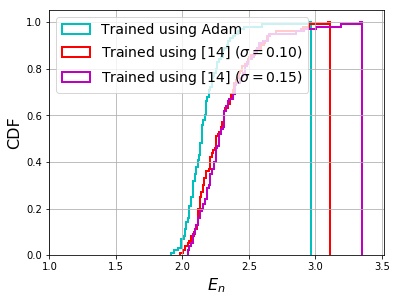

In [13]:
# colors = cycle(['b', 'g', 'r', 'c', 'm', 'y'])
# plt.figure(figsize=(8,6))
# selected_max_en = []
# for (model_exp,density_data) in results.items():
#     d = np.array([ en for (_,en) in density_data.items() ])
# #     if np.max(d) < 1.4*qam_en: # Avoid un-necessary models
#     plt.hist(d, bins=100, cumulative=True, histtype="step", label=model_exp, 
#              color=next(colors), linewidth=2, linestyle=":" if "Oshea" in model_exp else "-")
#     selected_max_en.append(np.max(d)) if np.max(d) < 1.5*qam_en else None
#     print(model_exp, "    Min:", np.min(d), "    Max:", np.max(d))
# plt.xlim([0.95*agrell_en,np.max(selected_max_en)*1.05])
# plt.plot([qam_en,qam_en], [0,100], linewidth=6, label="QAM", color=next(colors), linestyle=":")
# plt.plot([agrell_en,agrell_en], [0,100], linewidth=6, label="Agrell", color=next(colors), linestyle=":")
# plt.grid()
# plt.legend(loc='upper left', prop={'size':14})
# plt.title("Packing Density for ({},{})".format(blkSize,chDim), fontdict={'fontsize':18})
# plt.xlabel("$E_n$", fontdict={'fontsize':16})
# plt.ylabel("Distribution", fontdict={'fontsize':16})
# plt.savefig("output.eps", format='eps', bbox_inches='tight')

# colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
colors = cycle(['c', 'r', 'm', 'y', 'b', 'g'])
# plt.figure(figsize=(8,6))
plt.figure(figsize=(4*1.5,3*1.5))
# plt.plot([qam_en,qam_en], [0,1], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
# plt.plot([agrell_en,agrell_en], [0,1], linewidth=3, label="[9]", color=next(colors), linestyle="-.")
selected_max_en = []
for (model_exp,density_data) in results.items():
    d = np.array([ en for (_,en) in density_data.items() ])
#     if np.max(d) < 1.4*qam_en: # Avoid un-necessary models
    plt.hist(d, bins=100, cumulative=True, density=True, histtype="step", label=model_exp, 
             color=next(colors), linewidth=2, linestyle=":" if "Oshea" in model_exp or "[1]" in model_exp else "-")
    selected_max_en.append(np.max(d)) if np.max(d) < 1.8*qam_en else None
    print(model_exp, "    Min:", np.min(d), "    Max:", np.max(d))
plt.xlim([0.95*agrell_en,np.max(selected_max_en)*1.05])
plt.grid()
plt.legend(loc='upper left', prop={'size':14})
# plt.title("Packing Density for ({},{})".format(blkSize,chDim), fontdict={'fontsize':18})
plt.xlabel("$E_n$", fontdict={'fontsize':16})
plt.ylabel("CDF", fontdict={'fontsize':16})
plt.savefig("output_rbf_en_{:02d}x{:02d}.png".format(blkSize,chDim), format='png', bbox_inches='tight')
plt.savefig("output_rbf_en_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("output_rbf_en_{:02d}x{:02d}.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

Plot constellation for best models

In [ ]:
for (model_exp,density_data) in results.items():
    file_prefix = model_summary[model_exp].split("_summary.dil")[0]
    modelid = min(density_data, key=density_data.get)
    config_file = file_prefix + "_" + modelid + ".dil"
    config = {}
    model = None
    with open(config_file, "rb") as cfg_file:
        config = dill.load(cfg_file)
    if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
        model = CommVAE1hot()
    else:
        model = AEOshea1hot()
    model.load_model(file_prefix+"_"+modelid)
    # Compute TX Map
    dl_map = model.encode(one_hot_code)
    max_mag = np.max(np.abs(dl_map))
    tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]
    # Plot TX Map
    fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
    for i in range(chDim):
        _ax = ax if chDim==1 else ax[i]
        _ax.scatter(dl_map[:,i],dl_map[:,i+chDim],c=np.arange(inVecDim))
        for j in range(inVecDim):
            _ax.annotate( j, (dl_map[j,i],dl_map[j,i+chDim]) )
        _ax.set_title( "Channel Use {}".format(i+1) )
        _ax.grid()
        _ax.set_xticks(tick_points)
        _ax.set_yticks(tick_points)
        _ax.set_aspect('equal')
    fig.suptitle("{}  $E_n={:5.4f}$".format(model_exp,density_data[modelid]), fontsize=16)
      
    # Clear Session and Model
    K.clear_session()
    del model
    
# Plot QAM Model
fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
max_mag = np.max(np.abs(qam_map))
tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]    
for i in range(chDim):
    _ax = ax if chDim==1 else ax[i]
    _ax.scatter(qam_map[:,2*i], qam_map[:,2*i+1], c=np.arange(inVecDim))
    for j in range(inVecDim):
        _ax.annotate( j, (qam_map[j,2*i],qam_map[j,2*i+1]) )
    _ax.set_title( "Channel Use {}".format(i+1) )
    _ax.grid()
    _ax.set_xticks(tick_points)
    _ax.set_yticks(tick_points)
    _ax.set_aspect('equal')
fig.suptitle("{}  $E_n={:5.4f}$".format("QAM",qam_en), fontsize=16)

# Plot Agrell Model
fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
max_mag = np.max(np.abs(agrell_map))
tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]    
for i in range(chDim):
    _ax = ax if chDim==1 else ax[i]
    _ax.scatter(agrell_map[:,2*i], agrell_map[:,2*i+1], c=np.arange(inVecDim))
    for j in range(inVecDim):
        _ax.annotate( j, (agrell_map[j,2*i],agrell_map[j,2*i+1]) )
    _ax.set_title( "Channel Use {}".format(i+1) )
    _ax.grid()
    _ax.set_xticks(tick_points)
    _ax.set_yticks(tick_points)
    _ax.set_aspect('equal')
fig.suptitle("{}  $E_n={:5.4f}$".format("Agrell",agrell_en), fontsize=16)